<a href="https://colab.research.google.com/github/uprestel/AutoNeRF/blob/master/nerf_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NeRF Implementation
In this Notebook we do the following:
* load a small training set $\mathcal{T}$
* train NeRF on this training set
* generate a new training net $\hat{\mathcal{T}}$ using NeRF 


In [1]:
# Import all the good stuff


!git clone https://github.com/uprestel/AutoNeRF.git
import AutoNeRF.models.nerf as nerf
import AutoNeRF.data.data
from AutoNeRF.util.transforms import random_rotation, look_at_rotation

import torchvision
import sys
import torch



#!pip install pytorch3d


import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import os

# We import Pytorch3d to handle the camera transforms
#import pytorch3d
#from pytorch3d.transforms import random_rotation
#from pytorch3d.renderer.cameras import look_at_rotation


from google.colab import drive
drive.mount('/gdrive', force_remount=True)


Cloning into 'AutoNeRF'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 367 (delta 56), reused 0 (delta 0), pack-reused 245
Receiving objects: 100% (367/367), 34.06 MiB | 23.05 MiB/s, done.
Resolving deltas: 100% (187/187), done.
Mounted at /gdrive


## Load small dataset $\mathcal{T}$

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


data = np.load("/gdrive/My Drive/lego.npz")
# Images

images = data["images"]
# Camera extrinsics (poses)
tform_cam2world = data["poses"]
tform_cam2world = torch.from_numpy(tform_cam2world).to(device)
# Focal length (intrinsics)
focal_length = data["focal"]
focal_length = torch.from_numpy(focal_length).to(device)
print(tform_cam2world.shape)
# Height and width of each image
height, width = images.shape[1:3]

# Near and far clipping thresholds for depth values.
near_thresh = 2.
far_thresh = 6.

# Hold one image out (for test).
#testimg, testpose = images[102], tform_cam2world[102]
#testimg = torch.from_numpy(testimg).to(device)

# Map images to device
images = torch.from_numpy(images).to(device)

#testimg0 = images[1]
testimg = images[99, ..., :3]
#print(testimg0.shape, testimg.shape)
testpose = tform_cam2world[99]

#images = images[:99, ..., :3]


torch.Size([106, 4, 4])


#### Display the image used for testing

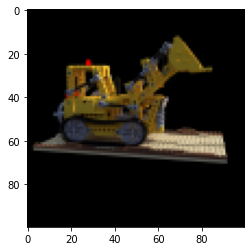

torch.float32
torch.Size([106, 4, 4])


In [4]:
plt.imshow(images[69].detach().cpu().numpy())
plt.show()
print(images[69].dtype)
print(tform_cam2world.shape)

In [ ]:
for i in range(0, 10):
    plt.imshow(images[i].detach().cpu().numpy())
    plt.show()

## Train NeRF


In [ ]:

# Number of functions used in the positional encoding (Be sure to update the 
# model if this number changes).
num_encoding_functions = 6
# Specify encoding function.
encode = lambda x: nerf.positional_encoding(x, num_encoding_functions=num_encoding_functions)
# Number of depth samples along each ray.
depth_samples_per_ray = 228

# Chunksize (Note: this isn't batchsize in the conventional sense. This only
# specifies the number of rays to be queried in one go. Backprop still happens
# only after all rays from the current "bundle" are queried and rendered).
chunksize = 16384  # Use chunksize of about 4096 to fit in ~1.4 GB of GPU memory.

# Optimizer parameters
lr = 5e-3
num_iters = 100000

# Misc parameters
display_every = 100  # Number of iters after which stats are displayed

"""
Model
"""
model = nerf.TinyNerfModel(num_encoding_functions=num_encoding_functions)
model.to(device)

"""
Optimizer
"""
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


Loss: 0.06932828575372696


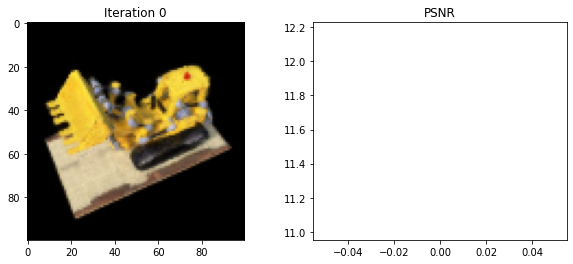

Loss: 0.07466083765029907


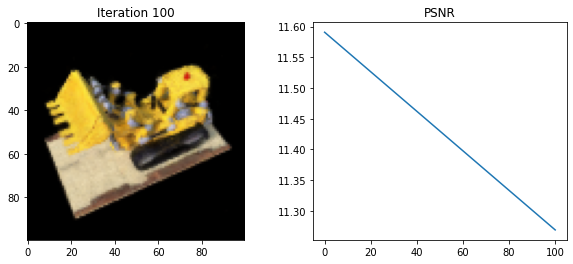

Loss: 0.12419985979795456


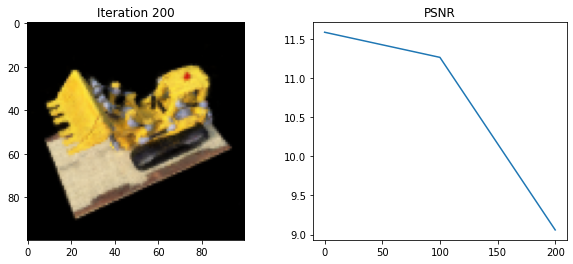

Loss: 0.09234973788261414


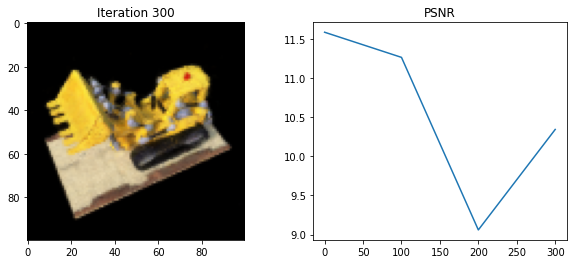

Loss: 0.13149109482765198


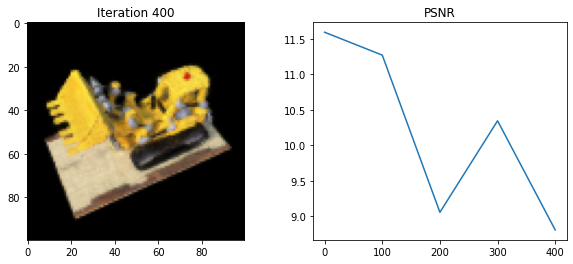

Loss: 0.0952063798904419


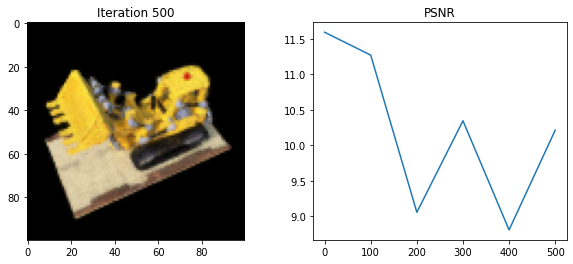

Loss: 0.09775374829769135


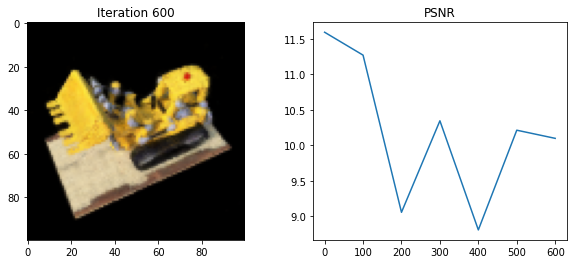

Loss: 0.06934169679880142


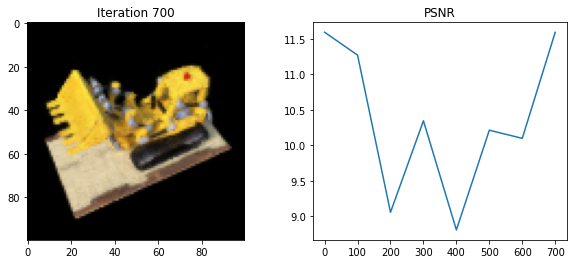

Loss: 0.06843932718038559


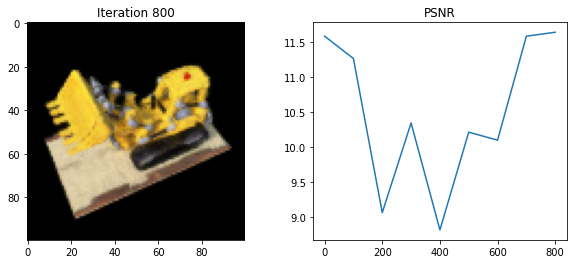

Loss: 0.07902343571186066


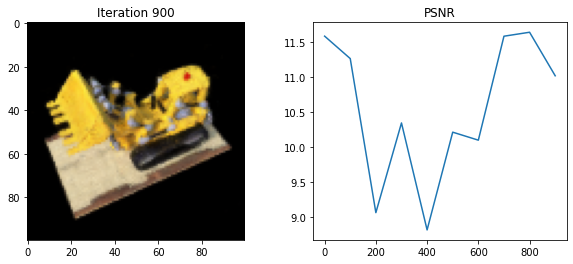

Loss: 0.14935579895973206


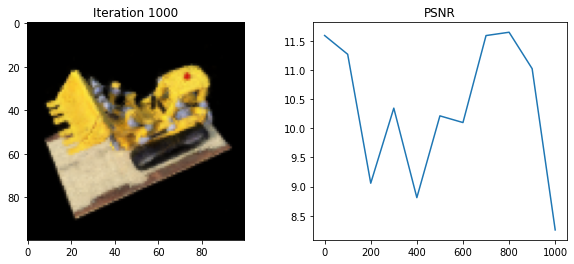

Loss: 0.1492561250925064


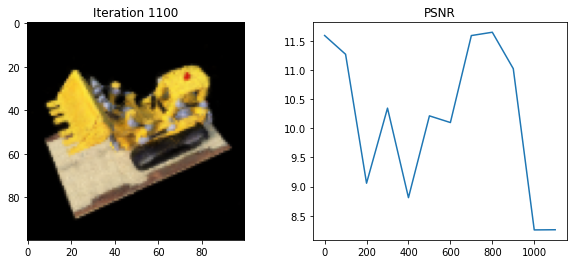

Loss: 0.12994970381259918


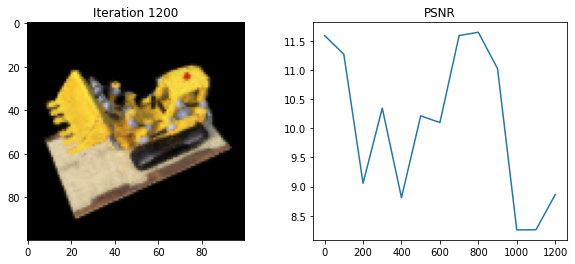

Loss: 0.11213624477386475


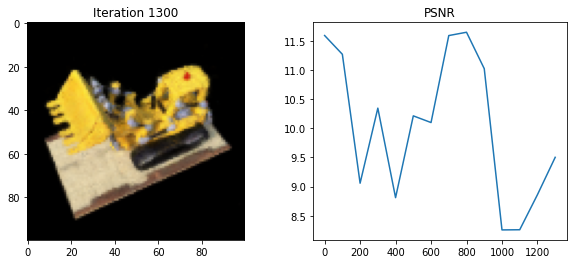

Loss: 0.1078510656952858


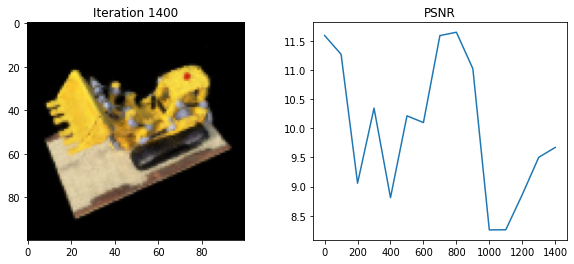

Loss: 0.1315443217754364


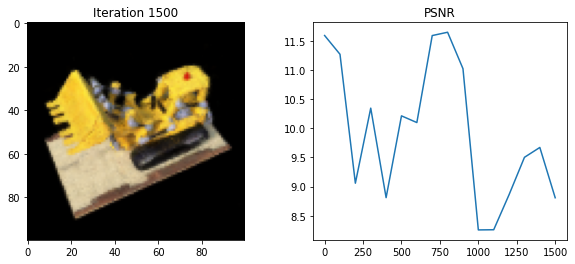

Loss: 0.1280588060617447


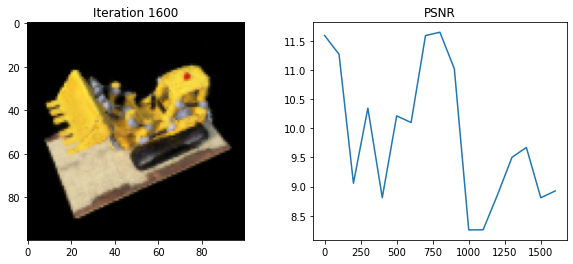

Loss: 0.14310643076896667


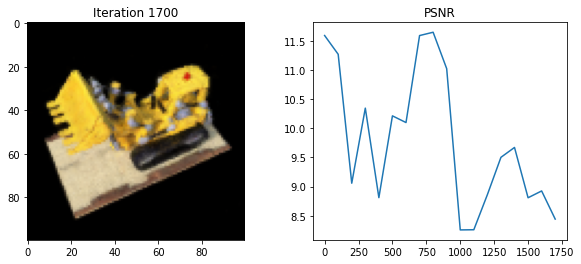

Loss: 0.12790633738040924


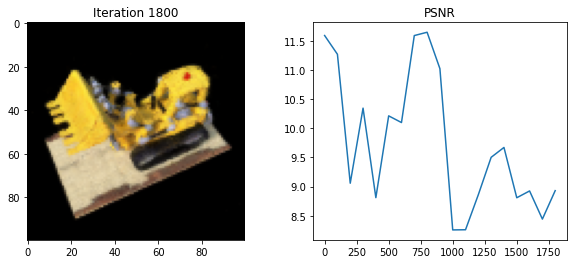

KeyboardInterrupt: ignored

In [ ]:

"""
Train-Eval-Repeat!
"""

# Seed RNG, for repeatability
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

# Lists to log metrics etc.
psnrs = []
iternums = []

near_thresh = 1.
far_thresh = 7.

for i in range(num_iters):

  # Randomly pick an image as the target.
  target_img_idx = np.random.randint(images.shape[0])
  target_img = images[target_img_idx].to(device)
  target_tform_cam2world = tform_cam2world[target_img_idx].to(device)

  # Run one iteration of TinyNeRF and get the rendered RGB image.
  rgb_predicted = nerf.run_one_iter_of_tinynerf(model, height, width, focal_length,
                                           target_tform_cam2world, near_thresh,
                                           far_thresh, depth_samples_per_ray,
                                           encode, nerf.get_minibatches)

  # Compute mean-squared error between the predicted and target images. Backprop!
  loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  # Display images/plots/stats
  if i % display_every == 0:
    # Render the held-out view
    rgb_predicted = nerf.run_one_iter_of_tinynerf(model, height, width, focal_length,
                                             testpose, near_thresh,
                                             far_thresh, depth_samples_per_ray,
                                             encode, nerf.get_minibatches)
    loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
    print("Loss:", loss.item())
    psnr = -10. * torch.log10(loss)
    
    psnrs.append(psnr.item())
    iternums.append(i)

    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.imshow(rgb_predicted.detach().cpu().numpy())
    plt.title(f"Iteration {i}")
    plt.subplot(122)
    plt.plot(iternums, psnrs)
    plt.title("PSNR")
    plt.show()

print('Done!')

## Save / load the model

In [ ]:
torch.save(model.state_dict(), "/gdrive/My Drive/nerf_lego.pt")
#torch.save(model.state_dict(), "/gdrive/My Drive/nerf_hotdog.pt")


In [5]:
#model = nerf.TinyNerfModel().to(device)
#model.load_state_dict(torch.load("/gdrive/My Drive/nerf_hotdog.pt"))
#model.eval()

model = nerf.TinyNerfModel().to(device)
model.load_state_dict(torch.load("/gdrive/My Drive/nerf_lego.pt"))
model.eval()

TinyNerfModel(
  (layer1): Linear(in_features=39, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (layer4): Linear(in_features=64, out_features=32, bias=True)
  (layer5): Linear(in_features=32, out_features=4, bias=True)
)

## Render novel views

In [6]:
translation = tform_cam2world[:, :3,3]
#center = torch.mean(translation, dim=0).to(device)
center = torch.zeros(3).to(device)
diff = center - translation

n = torch.norm(diff, p=2, dim=1)
radius = torch.mean(n)

print(radius, center)
#

radius = torch.norm(translation[0] - center, p=2)

print(radius, center)

UP = torch.tensor([0.,0.,1.]).unsqueeze(dim=0).to(device)

def get_new_pose(center, radius):
    """
    generates a new pose / perspective for the NeRF model
    """

    rot = random_rotation().to(device)
    unit_x = torch.tensor([1.,0.,0.]).to(device)
    new_t = center + radius*(rot @ unit_x)

    new_t[2] = torch.abs(new_t[2])


    cam_rot = look_at_rotation(at=new_t.unsqueeze(dim=0), 
                               camera_position=center.unsqueeze(dim=0),up=UP) #tform_cam2world[0, :3, :3]#

    #cam_rot = torch.transpose(cam_rot, 1,2)
    transform = torch.zeros((4,4))#.to(device)
    
    transform[:3, :3] = cam_rot
    transform[:3, 3] = new_t
    transform[3, 3] = 1
    #print(look_at_rotation(center))
    return transform

print(get_new_pose(center,radius))


tensor(4.0311, device='cuda:0') tensor([0., 0., 0.], device='cuda:0')
tensor(4.0311, device='cuda:0') tensor([0., 0., 0.], device='cuda:0')
tensor([[-0.3009, -0.2751,  0.9131,  3.6808],
        [ 0.9536, -0.0868,  0.2881,  1.1616],
        [ 0.0000,  0.9575,  0.2885,  1.1630],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


### sample new views
* our lego model can be contained in a ball $B_r(0)$ with $r=2$
* we only sample from our rays within this ball
* our radius (how far we are away from the camera) is sampled from $\mathcal{U}[r-1, r+1]$


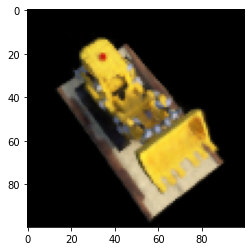

In [13]:
SCENE_RADIUS = 2


def get_thresholds(r):
    diff = r - SCENE_RADIUS
    tn = diff
    tf = diff + 2*SCENE_RADIUS
    #print(tn, tf, "ssss")
    return tn, tf
    

num_encoding_functions = 6
encode = lambda x: nerf.positional_encoding(x, num_encoding_functions=num_encoding_functions)

depth_samples_per_ray = 240

r = torch.tensor(np.random.uniform(radius.item()-1, radius.item()+1)).to(device)
near_thresh, fat_thresh = get_thresholds(r)

new_pose = get_new_pose(center, r).to(device)
predicted = nerf.nerf_inference(model, height, width, focal_length, new_pose,
                             near_thresh, far_thresh, depth_samples_per_ray,
                             encode, nerf.get_minibatches)

plt.imshow(predicted.detach().cpu().numpy())

## Render new dataset

To successfully train our generative model, we generate a temporary dataset $\hat{\mathcal{T}}$. 

In [ ]:
def show(image, permutation=(0,1,2)):
    grid_img = torchvision.utils.make_grid(image, nrow=5)
    plt.imshow(grid_img.permute(permutation))
    plt.axis('off')
    plt.show()


def swap_channels(x):
    return x.permute(0, 3, 1, 2).contiguous()

def unswap_channels(x):
    return x.permute(0, 2, 3, 1).contiguous()


num_encoding_functions = 6
encode = lambda x: nerf.positional_encoding(x, num_encoding_functions=num_encoding_functions)
depth_samples_per_ray = 240


poses = []
images = []
n_images = 30000
n_dataset = 10000

path = "/gdrive/My Drive/temp_dataset_lego_new.pt"
dataset = AutoNeRF.data.AutoNeRF_Dataset()

for i in range(n_images):

    r = torch.tensor(np.random.uniform(radius.item()-1, radius.item()+1)).to(device)
    near_thresh, fat_thresh = get_thresholds(r)
    new_pose = get_new_pose(center, r).to(device)
    predicted = nerf.nerf_inference(model, height, width, focal_length, new_pose,
                                near_thresh, far_thresh, depth_samples_per_ray,
                                encode, nerf.get_minibatches).cpu().detach().numpy()
    poses.append(new_pose.cpu().detach().numpy())
    images.append(predicted)
    

    
    del predicted
    del new_pose
    if i%1000==0:
        print("at iteration ", i)
        
    if (i+1) % n_dataset == 0 and i>0:
        
        # new now save the temporary dataset, since we have reached max capacity
        pth = os.path.splitext(path)
        filename = pth[-2] + str((i+1)//n_dataset)+ pth[-1]

        print("saving file with %s frames to %s" %(n_dataset, filename))
        poses_ = np.array(poses)
        images_ = np.array(images)

        dataset.pth = filename
        dataset.images = images_
        dataset.poses = poses_
        dataset.focal_length = np.array(focal_length.cpu().detach().numpy())
        dataset.save()
        # now we reset every variable and create a new dataset

        poses = []
        images = []
        dataset = AutoNeRF.data.AutoNeRF_Dataset()



#poses_ = np.array(poses)
#images_ = np.array(images)

#dataset.images = images_
#dataset.poses = poses_
#dataset.focal_length = np.array(focal_length.cpu().detach().numpy())
#split_dataset(dataset, 10000)
#dataset.save()

at iteration  0
at iteration  1000
at iteration  2000
at iteration  3000
at iteration  4000
at iteration  5000
at iteration  6000
at iteration  7000
at iteration  8000
at iteration  9000
saving file with 10000 frames to /gdrive/My Drive/temp_dataset_lego_new1.pt
at iteration  10000
at iteration  11000
at iteration  12000
at iteration  13000
at iteration  14000
at iteration  15000
at iteration  16000
at iteration  17000
at iteration  18000
at iteration  19000
saving file with 10000 frames to /gdrive/My Drive/temp_dataset_lego_new2.pt
at iteration  20000
at iteration  21000
at iteration  22000
at iteration  23000
at iteration  24000
at iteration  25000
at iteration  26000
at iteration  27000
at iteration  28000
at iteration  29000
saving file with 10000 frames to /gdrive/My Drive/temp_dataset_lego_new3.pt
